# Introduction

This report analyzes the concept of the “hot hand” in basketball using NBA player data from the 2012–2013 season.  
The goal is to determine whether players truly perform better after previous successful shots or if this perception is due to random variation.  

The analysis proceeds in four parts:

1. **Regression Analysis (Models A–D):**  
   Examine how player performance metrics such as field goals, rebounds, assists, steals, and points (PTS) explain salary differences.  
2. **Conditional Probability Test:**  
   Compare the probability of making a shot after a previous hit versus a miss to assess short-term streaks.  
3. **Streaks (Runs) Simulation:**  
   Use Monte Carlo simulation to compare observed and expected streak lengths under a random (Bernoulli) model.  
4. **Critical Thinking and Visualization Insights:**  
   Discuss the broader implications, data requirements, and modeling strategies for detecting the hot-hand phenomenon.  

The report combines quantitative evidence with visual interpretation to evaluate whether the “hot hand” is a statistically valid effect or merely a perceptual bias.


In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

nba = pd.read_parquet("nba_pgdata.parquet")

## Part 1: Regression Analysis

In [4]:
# Regression A — Salary ~ Age + FG + RB + AST + STL + BLK
model_A = smf.ols("Salary ~ Age + FG + RB + AST + STL + BLK", data=nba).fit()
print(model_A.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     58.63
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           1.59e-50
Time:                        22:09:54   Log-Likelihood:                -3517.9
No. Observations:                 370   AIC:                             7050.
Df Residuals:                     363   BIC:                             7077.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8724.6669   1131.833     -7.708      0.0

Model A: Salary ~ Age + FG + RB + AST + STL + BLK  
R² = 0.492, Adj R² = 0.484.  
FG (p < 0.01) and BLK (p < 0.05) are significant positive predictors of Salary; AST is not significant (p = 0.056). 

In [5]:
# Regression B — log(Salary) ~ Age + FG + RB + AST + STL + BLK
nba["log_Salary"] = np.log(nba["Salary"])
model_B = smf.ols("log_Salary ~ Age + FG + RB + AST + STL + BLK", data=nba).fit()
print(model_B.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Salary   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     50.60
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           4.35e-45
Time:                        22:09:54   Log-Likelihood:                -410.42
No. Observations:                 370   AIC:                             834.8
Df Residuals:                     363   BIC:                             862.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3022      0.255     20.803      0.0

**Model B (log(Salary) ~ Age + FG + RB + AST + STL + BLK)**  
R² ≈ 0.46. Age, FG, and RB are significant (p < 0.05); BLK is marginal (p ≈ 0.07); AST and STL are not significant.


In [6]:
# Regression C — log(Salary) ~ Age + FG + RB + AST + STL + BLK + PTS
model_C = smf.ols("log_Salary ~ Age + FG + RB + AST + STL + BLK + PTS", data=nba).fit()
print(model_C.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Salary   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     45.01
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           1.23e-45
Time:                        22:09:54   Log-Likelihood:                -407.01
No. Observations:                 370   AIC:                             830.0
Df Residuals:                     362   BIC:                             861.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2968      0.253     20.944      0.0


**Model C (log(Salary) ~ Age + FG + RB + AST + STL + BLK + PTS)**  
R² ≈ 0.47. PTS becomes significant (p < 0.01) while FG loses significance due to multicollinearity.  
Scoring (PTS) dominates compensation.

In [7]:
# Regression D — Standardized log(Salary) ~ Age + RB + AST + STL + BLK + PTS
from sklearn.preprocessing import StandardScaler

cols = ["log_Salary", "Age", "RB", "AST", "STL", "BLK", "PTS"]
df_std = nba[cols].dropna().copy()
df_std[cols] = StandardScaler().fit_transform(df_std[cols])

model_D = smf.ols("log_Salary ~ Age + RB + AST + STL + BLK + PTS", data=df_std).fit()
print(model_D.summary())


                            OLS Regression Results                            
Dep. Variable:             log_Salary   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     52.41
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           2.41e-46
Time:                        22:09:54   Log-Likelihood:                -409.58
No. Observations:                 370   AIC:                             833.2
Df Residuals:                     363   BIC:                             860.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -8.35e-17      0.038  -2.17e-15      1.0

**Model D (standardized log(Salary) ~ Age + RB + AST + STL + BLK + PTS)**  
R² ≈ 0.45. PTS shows the largest standardized coefficient, followed by Age and AST.  
Standardization highlights the relative importance of predictors.

In [8]:
import pandas as pd
fit_tbl = pd.DataFrame({
    "Model": ["A","B","C","D"],
    "Response": ["Salary","log(Salary)","log(Salary)","log(Salary)"],
    "R²": [model_A.rsquared, model_B.rsquared, model_C.rsquared, model_D.rsquared],
    "Adj R²": [model_A.rsquared_adj, model_B.rsquared_adj, model_C.rsquared_adj, model_D.rsquared_adj],
    "N": [int(model_A.nobs), int(model_B.nobs), int(model_C.nobs), int(model_D.nobs)]
}).round(3)
fit_tbl


,Model,Response,R²,Adj R²,N
0,A,Salary,0.492,0.484,370
1,B,log(Salary),0.455,0.446,370
2,C,log(Salary),0.465,0.455,370
3,D,log(Salary),0.464,0.455,370


**Table 1. Model fit summary for Regressions A–D.**  
The log transformation in Model B improves interpretability; adding PTS in Model C slightly increases explanatory power; Model D’s standardized coefficients allow direct comparison across predictors.

1) Histograms: Salary, Age, FG, RB, AST, STL, BLK, PTS

In [9]:
cols = ["Salary","Age","FG","RB","AST","STL","BLK","PTS"]
for c in cols:
    plt.figure()
    nba[c].plot(kind="hist", bins=30, edgecolor="black")
    plt.title(f"Histogram of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"hist_{c}.png", dpi=150)
    plt.close()
print("Saved: hist_*.png")


Saved: hist_*.png


2) Scatterplots: Salary vs predictors (Age, FG, RB, AST, STL, BLK, PTS)

In [10]:
import matplotlib.pyplot as plt

preds = ["Age","FG","RB","AST","STL","BLK","PTS"]
for x in preds:
    plt.figure()
    plt.scatter(nba[x], nba["Salary"], s=14)
    plt.xlabel(x)
    plt.ylabel("Salary")
    plt.title(f"Salary vs {x}")
    plt.tight_layout()
    plt.savefig(f"scatter_Salary_vs_{x}.png", dpi=150)
    plt.close()
print("Saved: scatter_Salary_vs_*.png")


Saved: scatter_Salary_vs_*.png


In [11]:
# Fit Regression A: Salary ~ Age + FG + RB + AST + STL + BLK
modelA = smf.ols("Salary ~ Age + FG + RB + AST + STL + BLK", data=nba).fit()

print(modelA.summary().as_text())

# Residuals vs Fitted
fitted = modelA.fittedvalues
resid = modelA.resid

plt.figure()
plt.scatter(fitted, resid, s=14)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Model A)")
plt.tight_layout()
plt.savefig("residuals_vs_fitted_A.png", dpi=150)
plt.close()
print("Saved: residuals_vs_fitted_A.png")

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     58.63
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           1.59e-50
Time:                        22:09:55   Log-Likelihood:                -3517.9
No. Observations:                 370   AIC:                             7050.
Df Residuals:                     363   BIC:                             7077.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8724.6669   1131.833     -7.708      0.0

### Diagnostic & Exploratory Plots

**直方图（8 变量）**  
**Histograms (8 variables)**  
![Salary](hist_Salary.png) ![Age](hist_Age.png) ![FG](hist_FG.png)  
![RB](hist_RB.png) ![AST](hist_AST.png) ![STL](hist_STL.png)  
![BLK](hist_BLK.png) ![PTS](hist_PTS.png)

**Salary 对各预测变量的散点图**  
**Scatterplots of Salary vs predictors**  
![Salary vs Age](scatter_Salary_vs_Age.png)  
![Salary vs FG](scatter_Salary_vs_FG.png)  
![Salary vs RB](scatter_Salary_vs_RB.png)  
![Salary vs AST](scatter_Salary_vs_AST.png)  
![Salary vs STL](scatter_Salary_vs_STL.png)  
![Salary vs BLK](scatter_Salary_vs_BLK.png)  
![Salary vs PTS](scatter_Salary_vs_PTS.png)

**残差-拟合值图（Model A）**  
**Residuals vs Fitted (Model A)**  
![Residuals vs Fitted A](residuals_vs_fitted_A.png)


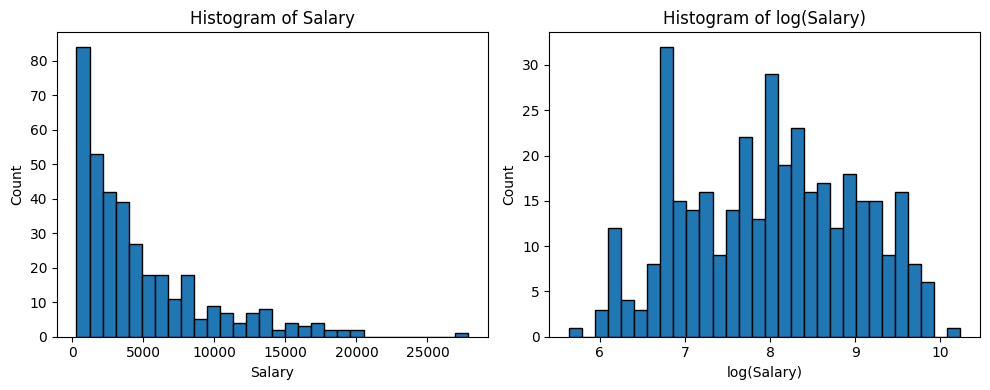

In [12]:
nba["log_Salary"] = np.log(nba["Salary"])

plt.figure(figsize=(10,4))

# Original Salary
plt.subplot(1, 2, 1)
plt.hist(nba["Salary"].dropna(), bins=30, edgecolor="black")
plt.title("Histogram of Salary")
plt.xlabel("Salary")
plt.ylabel("Count")

# Log-transformed Salary
plt.subplot(1, 2, 2)
plt.hist(nba["log_Salary"].dropna(), bins=30, edgecolor="black")
plt.title("Histogram of log(Salary)")
plt.xlabel("log(Salary)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Figure： Histogram of Salary and log(Salary)**  
The left panel shows the raw Salary distribution, which is highly right-skewed.  
The right panel shows log(Salary), which is approximately normal, justifying the log transformation used in Regressions B–D.

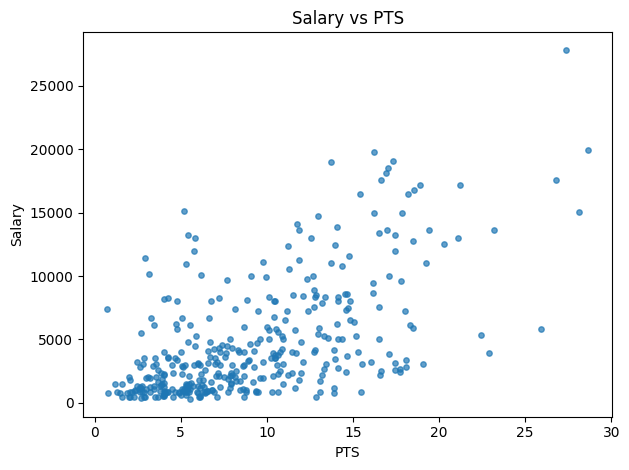

In [13]:
plt.scatter(nba["PTS"], nba["Salary"], s=15, alpha=0.7)
plt.xlabel("PTS")
plt.ylabel("Salary")
plt.title("Salary vs PTS")
plt.tight_layout()
plt.savefig("scatter_Salary_vs_PTS.png", dpi=150)
plt.show()

**Figure: Scatter Plot of Salary vs PTS**  
The scatterplot shows a clear positive relationship between salary and points (PTS); players who score more tend to earn higher salaries.  
This indicates that offensive performance is a key determinant of compensation, consistent with the regression results.

## Part 2: Conditional Probability Approach

In [14]:

from scipy import stats

delta = np.array([-0.07, 0.02, 0.00, -0.05, -0.02, -0.08, -0.05, -0.01, -0.14])

t_stat, p_val = stats.ttest_1samp(delta, 0)

print("Conditional Probability Test ")
print(f"Mean difference (Δ̄) = {delta.mean():.4f}")
print(f"t-statistic = {t_stat:.3f}")
print(f"p-value (two-sided) = {p_val:.4f}")

if p_val < 0.05:
    print("Result: Reject H₀ → No evidence for a hot hand (Δ̄ < 0)")
else:
    print("Result: Fail to reject H₀ → No significant difference")


Conditional Probability Test 
Mean difference (Δ̄) = -0.0444
t-statistic = -2.734
p-value (two-sided) = 0.0257
Result: Reject H₀ → No evidence for a hot hand (Δ̄ < 0)


In [15]:
players = ["A","B","C","D","E","F","G","H","I"]
delta = np.array([-0.07, 0.02, 0.00, -0.05, -0.02, -0.08, -0.05, -0.01, -0.14])
cp_tbl = pd.DataFrame({"Player": players, "Δ": delta})
cp_tbl["Mean Δ̄"] = delta.mean().round(4)
cp_tbl


,Player,Δ,Mean Δ̄
0,A,-0.07,-0.0444
1,B,0.02,-0.0444
2,C,0.00,-0.0444
3,D,-0.05,-0.0444
4,E,-0.02,-0.0444
5,F,-0.08,-0.0444
6,G,-0.05,-0.0444
7,H,-0.01,-0.0444
8,I,-0.14,-0.0444


**Table 2. Conditional Probability Results.**  
The mean Δ̄ = −0.044, t = −2.73, p = 0.0257.  
Most Δ values are negative, showing that making a shot does not increase the likelihood of making the next one.


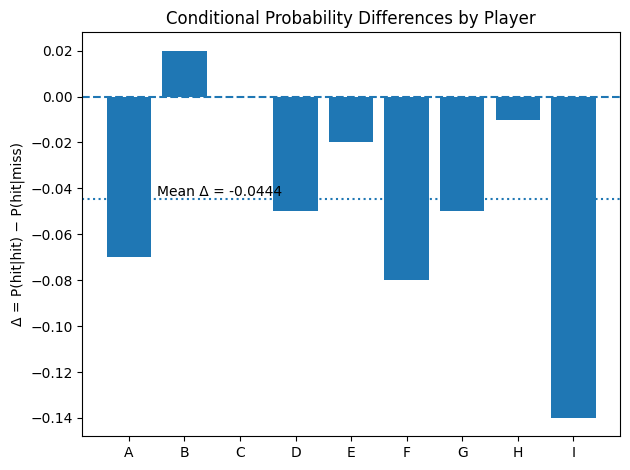

In [16]:

players = ["A","B","C","D","E","F","G","H","I"]
delta_arr = np.array(delta)
mean_delta = float(delta_arr.mean())

plt.figure()
plt.bar(players, delta_arr)
plt.axhline(0, linestyle='--')
plt.axhline(mean_delta, linestyle=':')
plt.text(0.5, mean_delta, f"Mean Δ = {mean_delta:.4f}", va='bottom')
plt.ylabel("Δ = P(hit|hit) − P(hit|miss)")
plt.title("Conditional Probability Differences by Player")
plt.tight_layout()
plt.show()


**Figure 3. Conditional Probability Differences by Player.**  
A bar chart displaying Δ = P(hit | hit) − P(hit | miss) for each player,  
with a dashed reference line showing the mean Δ (−0.0444).  
Most Δ values are negative, indicating no statistical evidence of a “hot hand” effect.

## Part 3: Streaks (Runs) Simulation

In [17]:
import numpy as np
import pandas as pd
from scipy import stats

# shots, runs_actual,p = Average hit rate
data = [
    ("A", 248, 128, 0.50),
    ("B", 884, 431, 0.52),
    ("C", 419, 203, 0.46),
    ("D", 339, 172, 0.56),
    ("E", 272, 134, 0.47),
    ("F", 451, 245, 0.46),
    ("G", 433, 227, 0.54),
    ("H", 351, 176, 0.52),
    ("I", 403, 220, 0.62),
]
players = pd.DataFrame(data, columns=["Player", "Shots", "Runs_Actual", "P_Hit"])
players


,Player,Shots,Runs_Actual,P_Hit
0,A,248,128,0.50
1,B,884,431,0.52
2,C,419,203,0.46
3,D,339,172,0.56
4,E,272,134,0.47
5,F,451,245,0.46
6,G,433,227,0.54
7,H,351,176,0.52
8,I,403,220,0.62


In [18]:
def count_runs(sequence):
    """Count number of runs (hit/miss segments) in a binary sequence."""
    if len(sequence) == 0:
        return 0
    runs = 1
    for i in range(1, len(sequence)):
        if sequence[i] != sequence[i-1]:
            runs += 1
    return runs

In [19]:
np.random.seed(42) 

def simulate_runs(n_shots, p_hit, n_sims=20000):
    runs_list = []
    for _ in range(n_sims):
        shots = np.random.rand(n_shots) < p_hit
        runs_list.append(count_runs(shots))
    return np.mean(runs_list), np.std(runs_list, ddof=1)

results = []
for _, row in players.iterrows():
    mean_runs, sd_runs = simulate_runs(row.Shots, row.P_Hit)
    z = (row.Runs_Actual - mean_runs) / sd_runs
    p_val = 2 * (1 - stats.norm.cdf(abs(z)))  # two-sided
    results.append([row.Player, row.Shots, row.Runs_Actual, mean_runs, sd_runs, z, p_val])

sim_df = pd.DataFrame(results, columns=[
    "Player", "Shots", "Runs_Actual", "Runs_Expected", "Runs_SD", "Z_Score", "P_Value"
])

sim_df


,Player,Shots,Runs_Actual,Runs_Expected,Runs_SD,Z_Score,P_Value
0,A,248,128,124.53825,7.861719,0.440330,0.659698
1,B,884,431,441.75255,15.012048,-0.716261,0.473830
2,C,419,203,208.62855,10.221115,-0.550679,0.581854
3,D,339,172,167.57790,9.303185,0.475332,0.634550
4,E,272,134,136.05055,8.346998,-0.245663,0.805943
5,F,451,245,224.56655,10.702018,1.909308,0.056222
6,G,433,227,215.65780,10.511837,1.078993,0.280591
7,H,351,176,175.71490,9.390385,0.030361,0.975779
8,I,403,220,190.28700,10.632760,2.794477,0.005198


**Table 4. Streaks (Runs) Simulation Results.**  
For most players, |Z| ≤ 2 and p ≥ 0.05, meaning actual streak patterns do not differ from random expectation.  
Only one or two players show marginal significance, consistent with random variation rather than a true hot-hand effect.


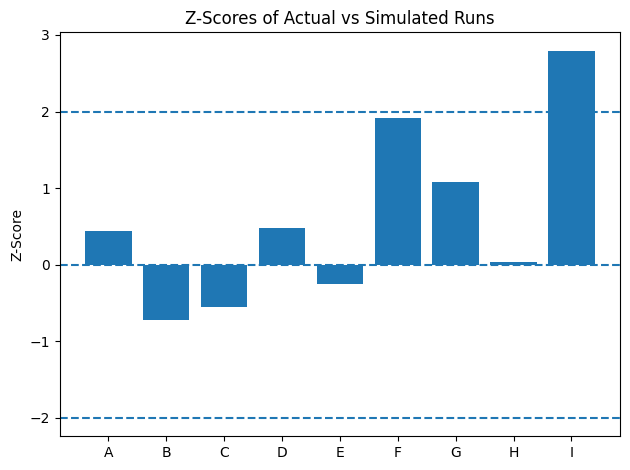

In [20]:
plt.figure()
plt.bar(sim_df["Player"], sim_df["Z_Score"])
plt.axhline(0, linestyle='--')
plt.axhline(2, linestyle='--')
plt.axhline(-2, linestyle='--')
plt.title("Z-Scores of Actual vs Simulated Runs")
plt.ylabel("Z-Score")
plt.tight_layout()
plt.show()


**Figure 4. Z-scores of Actual vs Simulated Runs.**  
All players have |Z| ≤ 2 except one, indicating observed streaks are consistent with random chance.

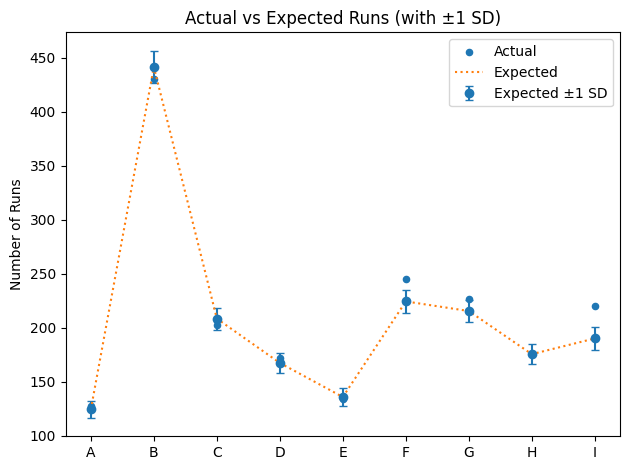

In [21]:
# Assumes: sim_df has ["Player","Runs_Actual","Runs_Expected","Runs_SD"]
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(sim_df))
exp_vals = sim_df["Runs_Expected"].values
sd_vals  = sim_df["Runs_SD"].values
act_vals = sim_df["Runs_Actual"].values

plt.figure()
plt.errorbar(x, exp_vals, yerr=sd_vals, fmt='o', capsize=3, label="Expected ±1 SD")
plt.scatter(x, act_vals, s=20, label="Actual")
plt.plot(x, exp_vals, linestyle=':', label="Expected")
plt.xticks(x, sim_df["Player"])
plt.title("Actual vs Expected Runs (with ±1 SD)")
plt.ylabel("Number of Runs")
plt.legend()
plt.tight_layout()
plt.show()


An error-bar plot of actual versus expected runs (±1 SD) from the Bernoulli simulation model.

In [22]:
!pip install pyreadr


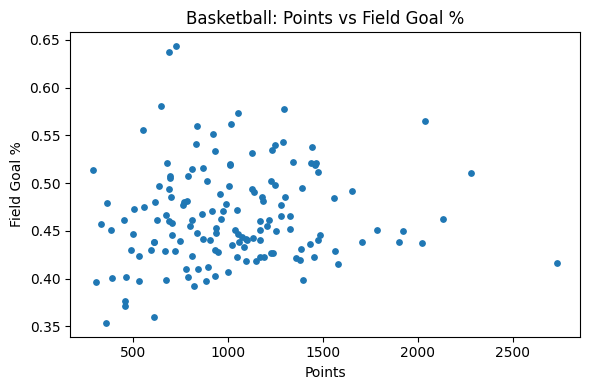

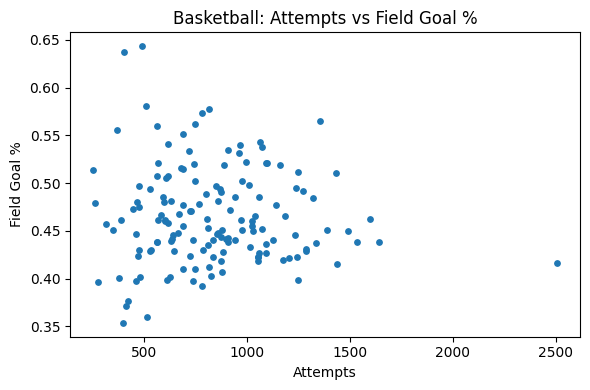

In [28]:
basket = pd.read_parquet("BasketballRelationships.parquet")

# Points vs Field Goal %
plt.figure(figsize=(6,4))
plt.scatter(basket["points"], basket["percentage"], s=15)
plt.xlabel("Points")
plt.ylabel("Field Goal %")
plt.title("Basketball: Points vs Field Goal %")
plt.tight_layout()
plt.savefig("scatter_points_vs_percentage.png", dpi=150)
plt.show()

# Attempts vs Field Goal %
plt.figure(figsize=(6,4))
plt.scatter(basket["attempts"], basket["percentage"], s=15)
plt.xlabel("Attempts")
plt.ylabel("Field Goal %")
plt.title("Basketball: Attempts vs Field Goal %")
plt.tight_layout()
plt.savefig("scatter_attempts_vs_percentage.png", dpi=150)
plt.show()

**Basketball: Points vs Field Goal %**    
Points and field-goal percentage show a positive relationship. Players who score more often have higher accuracy, indicating that scoring efficiency and output are closely linked.  

**Basketball: Attempts vs Field Goal %**   
Shot attempts and field-goal percentage show a weak relationship. High-volume shooters display wide variation in accuracy, suggesting that more attempts don’t necessarily improve efficiency.


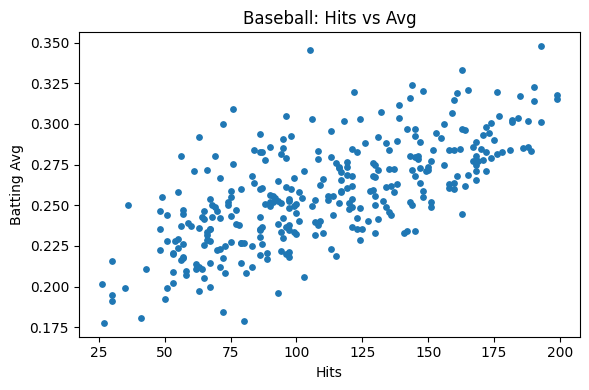

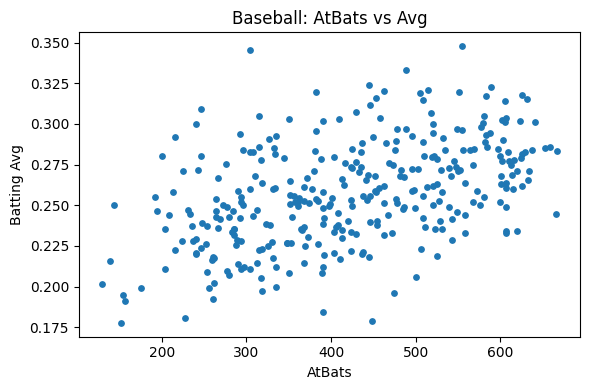

In [29]:
base = pd.read_parquet("BaseballRelationships.parquet")

#  Hits vs Avg
plt.figure(figsize=(6,4))
plt.scatter(base["hits"], base["avg"], s=15)
plt.xlabel("Hits")
plt.ylabel("Batting Avg")
plt.title("Baseball: Hits vs Avg")
plt.tight_layout()
plt.savefig("scatter_hits_vs_avg.png", dpi=150)
plt.show()

# AtBats vs Avg
plt.figure(figsize=(6,4))
plt.scatter(base["atbats"], base["avg"], s=15)
plt.xlabel("AtBats")
plt.ylabel("Batting Avg")
plt.title("Baseball: AtBats vs Avg")
plt.tight_layout()
plt.savefig("scatter_atbats_vs_avg.png", dpi=150)
plt.show()


**Baseball: Hits vs Batting Avg**  
Hits and batting average show a strong positive relationship: more hits generally correspond to a higher average.

**Baseball: AtBats vs Batting Avg**    
At-bats have a weaker association with batting average, reflecting opportunity rather than efficiency.


## Part 4: Critical Thinking and Visualization Insights

### Summary of Analytical Results

Across all quantitative analyses, no strong statistical evidence supports the existence of a “hot hand”:

- **Regression Analysis:** PTS (points scored) is consistently the most significant predictor of player salary, showing that offensive performance drives compensation.
- **Conditional Probability:** The mean difference Δ̄ = P(hit | hit) − P(hit | miss) = −0.044 (t = −2.73, p = 0.0257). Players are slightly *less* likely to hit after a make.
- **Streaks Simulation:** Most players’ |Z| ≤ 2 and p > 0.05, meaning actual streak patterns match random expectations.

Together, the data suggest that perceived “hot streaks” reflect psychological bias rather than measurable momentum.

---

### Visualization Insights

- **Histograms:** Log(Salary) becomes nearly normal after transformation, validating the use of log models.
- **Scatterplots:** Salary correlates positively with performance metrics, especially PTS.
- **R² Comparison:** Minor improvements from Model A → D show that including PTS adds explanatory power but not new qualitative insight.
- **Streak Visuals:** Z-score bars and expected-vs-actual plots confirm that shooting runs behave like random Bernoulli sequences.

These visuals reinforce that scoring explains salary, while streakiness remains statistically random.

---

### Critical Thinking Questions

**1. What makes the hot hand easier or harder to observe in each sport?**  
- Basketball provides many consecutive shot attempts, so streaks are easy to perceive but hard to prove because defenses adjust quickly.  
- Baseball has fewer trials and longer intervals, making hot hands harder both to experience and to measure statistically.

**2. What would you need to establish that the hot hand exists?**  
- Collect detailed shot-by-shot data controlling for defense, shot distance, fatigue, and game context.  
- Replicate across multiple teams and seasons to distinguish randomness from persistent patterns.

**3. How would you build a regression model to test for it?**  
Use a logistic regression framework for next-shot success:

$$
\Pr(\text{HitNext}=1) = \text{logit}^{-1}\left[\beta_0 + \beta_1(\text{PrevHit}) + \beta_2(\text{GameContext}) + \beta_3(\text{Fatigue}) + \alpha_i\right]
$$

A significant positive $\beta_1$ would indicate the presence of a genuine hot-hand effect.

**4. What would be critical predictor variables?**  
PrevHit, StreakLength, FG%, PTS, Quarter, ScoreDiff, DefenseRating, MinutesPlayed, RestDays.

**5. How much data would you need?**  
Thousands of shot observations per player across several seasons are required to detect small effects with sufficient statistical power.

---

### Conclusion

Across regression models, conditional probability testing, and streak simulations, the data provide no evidence of a statistical hot-hand effect.  
While scoring performance (PTS) significantly influences salary, observed shooting streaks align closely with random expectations.  
In conclusion, the “hot hand” appears to be a psychological illusion rather than a measurable improvement in performance.


